In [ ]:
# jun@hirax.net
# twitter: @hirax

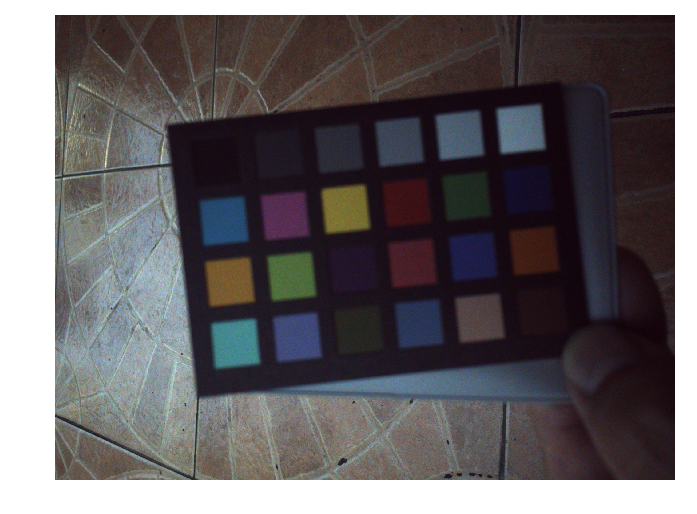

In [25]:
%matplotlib inline

import matplotlib.pyplot as plt; import matplotlib.image as mpimg
import numpy as np

# RAW画像をnp.arrayとしてシリアライズした内容は、r,g,bをindexとしたリスト
rgb = np.load( 'test003_iso_050_timescale_240.DNG.npz' ) 
linImage =  np.stack( [ rgb['r'], rgb['g'], rgb['b'] ],  axis=2 ) 
maxvals = np.zeros( 3 ); minvals = np.zeros( 3 )
for i in range(3): # RGBごとの光量特性差があるので、それぞれ最少値・最大値で正規化
    maxvals[ i ] = np.max( linImage[ :, :, i ] );  minvals[ i ] = np.min( linImage[ :, :, i ] )
    linImage[ :, :, i ]= ( linImage[ :, :, i ] - minvals[ i ] ) / ( maxvals[ i ] - minvals[ i ] )
plt.figure( figsize=( 8, 8 ), dpi=100 ); plt.axis( "off" ); plt.imshow( image )

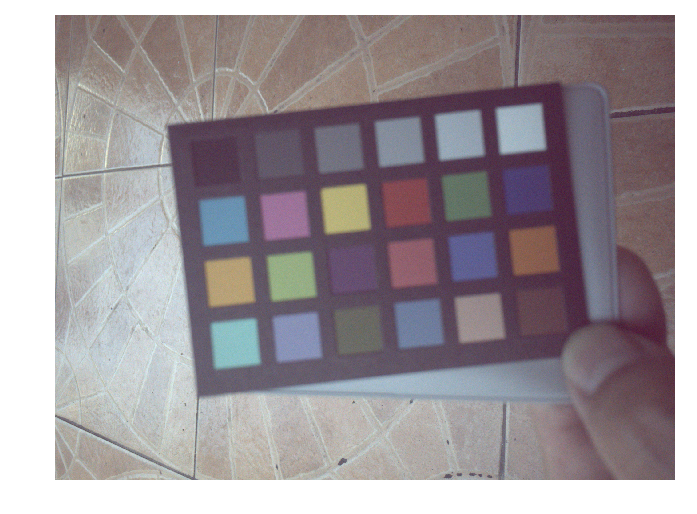

In [5]:
def lin2srgb( lin ):   # 光量に線形なＲＧＢ値をsRGB値に変換
    if lin > 0.0031308:
            return  1.055 * ( pow( lin, ( 1.0 / 2.4 ) ) ) - 0.055
    else:
            return 12.92 * lin

def linImg2srgbImg( linImg ): # 光量画像をsRGB画像に変換
    sRGBimage=np.zeros_like( linImg )
    for h in range( len( linImg ) ): 
        for w in range( len( linImg[0] ) ): 
            for i in range( 3 ):
                sRGBimage[ h, w, i ] = lin2srgb( linImg[ h, w, i ] )
    return sRGBimage

sRGBimage = linImg2srgbImg( linImage )  # モニタ表示や記事入稿用にsRGB変換
plt.figure( figsize = ( 8, 8 ), dpi = 100 ); plt.axis( "off" ); plt.imshow( sRGBimage )

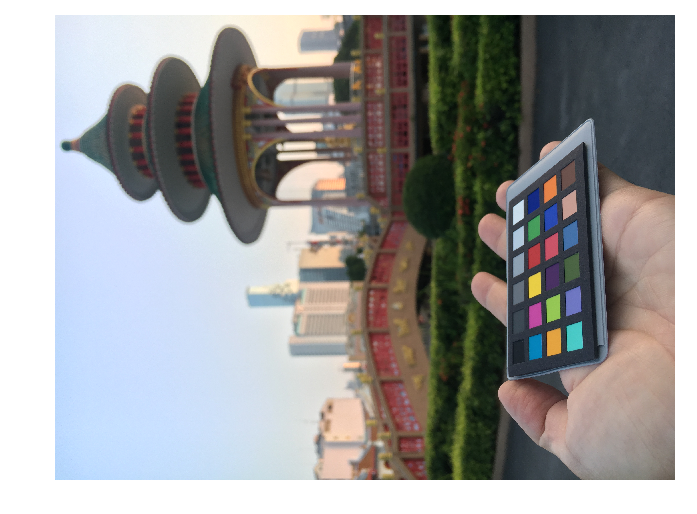

In [10]:
# （カラーパッチを入れ込んだ）sRGB画像を読み込み光量画像に変換する
from PIL import Image
img = np.array( Image.open( 'IMG_1445.JPG' ) )
img = ( img ).astype(np.float) / 255. # 8 bit =最大255で除して0-1にする
plt.figure( figsize=( 8, 8 ), dpi=100 ); plt.axis( "off" ); plt.imshow( img )

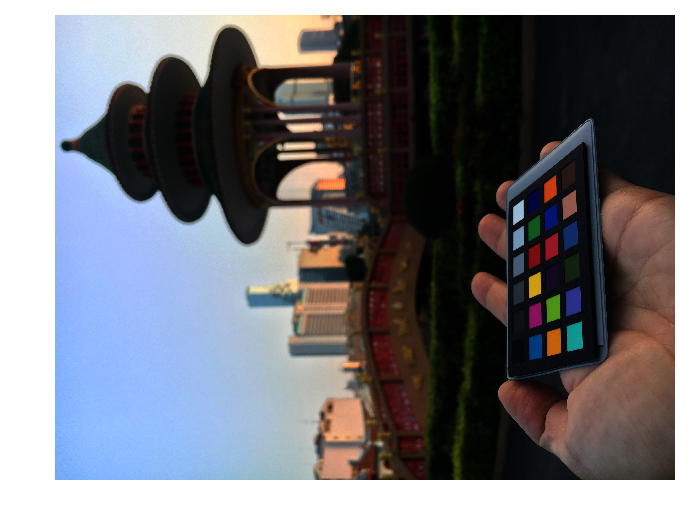

In [12]:
def srgb2lin( s ): # sRGB画素値を光量値に変換
    if s <= 0.0404482362771082:
        return s / 12.92
    else:
        return pow( ( ( s + 0.055 ) / 1.055 ), 2.4 )
# sRGB画像を光量画像に変換
def srgbImg2linImg( srgbImg ): 
    linImg = np.zeros_like( srgbImg )
    for h in range( len( srgbImg ) ): 
        for w in range( len( srgbImg[0] ) ): 
            for i in range( 3 ):
                linImg[ h, w, i ] = srgb2lin( srgbImg[ h, w, i ] )
    return linImg

linImg = srgbImg2linImg( img ) # sRGB画像を光量線形画像に変換
plt.figure( figsize=( 8, 8 ), dpi=100 ); plt.axis( "off" ); plt.imshow( linImg )

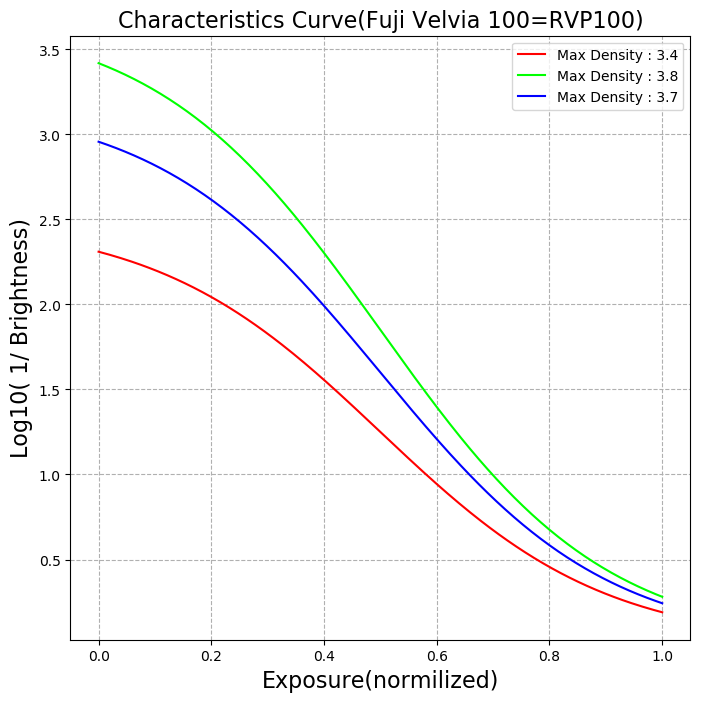

In [30]:
# フィルムの特性曲線関数を作り、描いてみる

# フィルムの特性曲線関数用に、シグモイド関数を定義
def sigmoid(x, minVal, maxVal, d ): # 入力、最小・最大濃度、非線形性
    return ( maxVal - minVal ) / (1 + np.exp( -d * ( x-0.5 ) ) )+minVal

fig = plt.figure( figsize=( 8, 8 ), dpi=100 );
ax = fig.add_subplot(111);  ax.grid(linestyle = "--")
ax.set_title("Characteristics Curve(Fuji Velvia 100=RVP100)", fontsize =16)
ax.set_xlabel( "Exposure(normilized)", fontsize =16)
ax.set_ylabel( "Log10( 1/ Brightness)", fontsize =16)
x = np.linspace(0, 1, 256); y = sigmoid(x, 1, 0, 5. )
ax.plot(x, 2.5*y, label = "Max Density : {}".format( 3.4 ), color=(1,0,0)) #  R
ax.plot(x, 3.7*y, label = "Max Density : {}".format( 3.8 ), color=(0,1,0)) # G
ax.plot(x, 3.2*y, label = "Max Density : {}".format( 3.7 ), color=(0,0,1)) # B
ax.legend()

In [31]:
# 「銀塩写真フィルムの特性曲線」を使い、光量画像を（濃度を介して）画像に変換する
def exposure2Density( linImg, latitude_top, latitude_bottom, 
                     max_densities ): # max_densitiesは[r, g, b]
    latitude = latitude_top - latitude_bottom # 表現域は10**latitude
    img = np.zeros_like( linImg )
    for y in range( len( linImg ) ):
        for x in range( len( linImg[0] ) ):
            for i in range(3):
                exposureLog = np.log10( linImg[y, x, i] ) #  この事典では0 〜 -∞
                # 0〜 - latitude を1〜0にマッピングする
                normilizedExposureLog = ( exposureLog + latitude ) / latitude
                density = sigmoid( normilizedExposureLog, 
                        max_densities[ i ], 0,3 ) # 最小濃度は0, シグモイド形状は3で固定
                img[ y, x, i ] = 1.0/10**( density )
    return img

/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


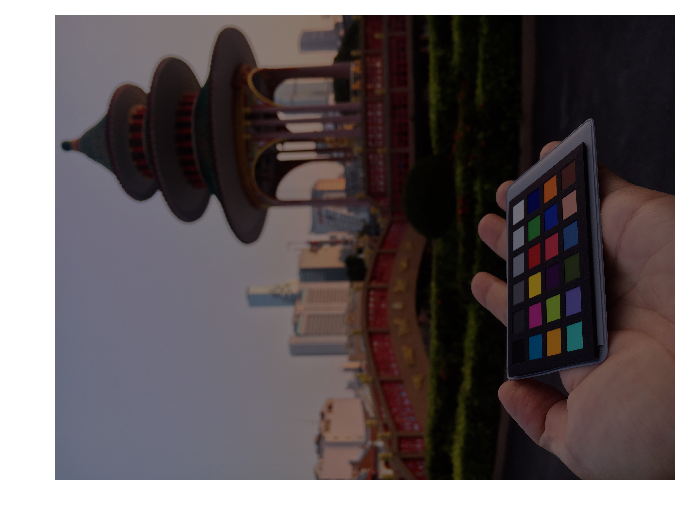

In [32]:
# カラーチャート撮影画像を、試しにフィルム（階調・色調）再現処理してみる
# （使用特性は Fuji Velvia 100）
linImg = srgbImg2linImg( img ) # sRGB画像を光量線形画像に変換
filmImg = exposure2Density( linImg, 1, -1, [3.4, 3.8, 3.7] ) # Fuji Velvia 100
sRGBFilmImage = linImg2srgbImg( filmImg )
plt.figure( figsize=(8, 8), dpi=100 ); plt.axis( "off" ); plt.imshow( sRGBFilmImage )

/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


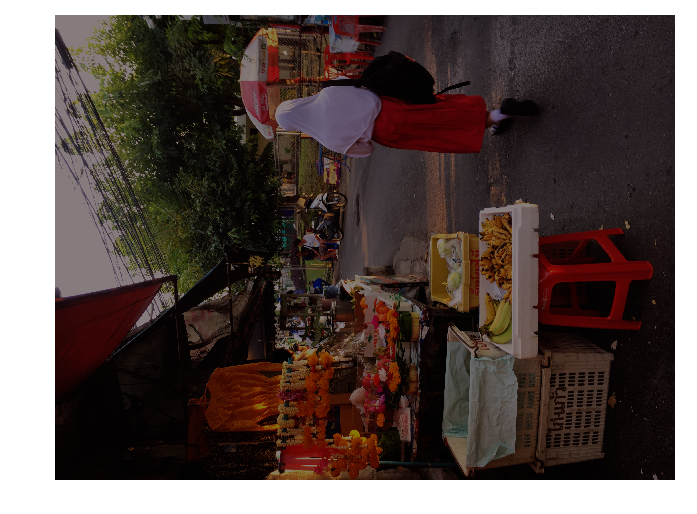

In [33]:
# JPEG撮影画像をフィルム（階調・色調）再現処理してみる
# （使用特性は Fuji Velvia 100）
img = np.array( Image.open( 'IMG_1706.JPG' ) ) 
img = ( img ).astype(np.float) / 255. # 8 bit =最大255で除して0-1にする
linImg = srgbImg2linImg( img ) # sRGB画像を光量線形画像に変換
filmImg = exposure2Density( linImg, 1, -1, [3.4, 3.8, 3.7] ) # Fuji Velvia 100
sRGBFilmImage = linImg2srgbImg( filmImg )
plt.figure( figsize=(8, 8), dpi=100 ); plt.axis( "off" ); plt.imshow( sRGBFilmImage )


/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


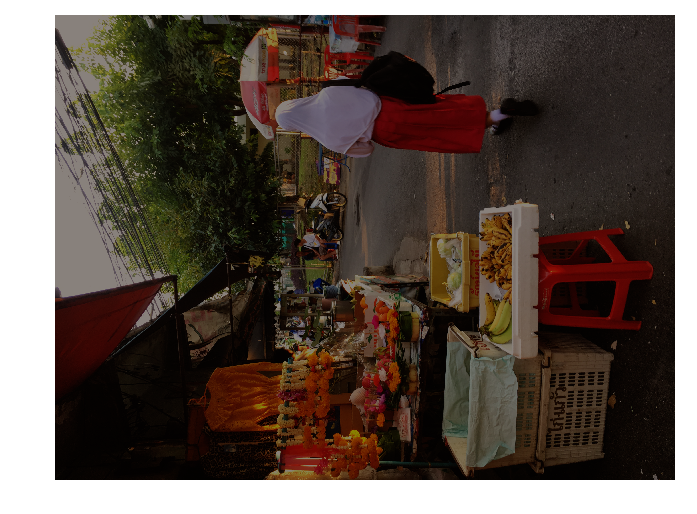

In [34]:
# JPEG撮影画像をフィルム（階調・色調）再現処理してみる
# （使用特性は Kodak Ektachrome 100s）

img = np.array( Image.open( 'IMG_1706.JPG' ) ) 
img = ( img ).astype(np.float) / 255. # 8 bit =最大255で除して0-1にする
linImg = srgbImg2linImg( img ) # sRGB画像を光量線形画像に変換
filmImg = exposure2Density( linImg, 1, -1, [3.3, 3.6,3.8] ) # Kodak Ektachrome 100s 
sRGBFilmImage = linImg2srgbImg( filmImg )
plt.figure( figsize=(8, 8), dpi=100 ); plt.axis( "off" ); plt.imshow( sRGBFilmImage )



/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


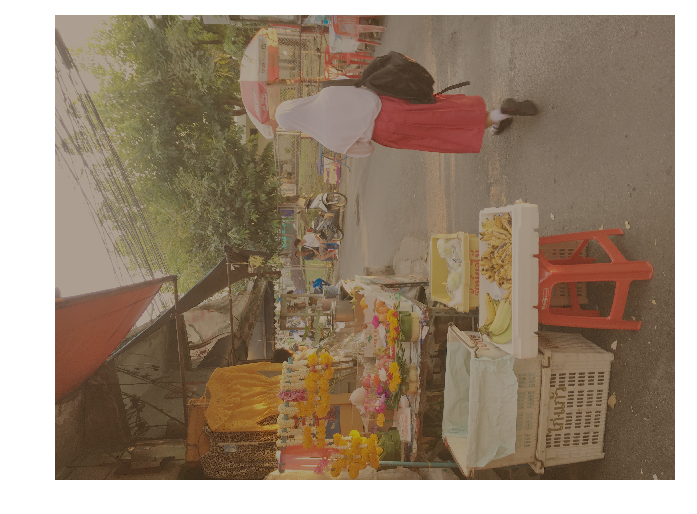

In [35]:
# JPEG撮影画像をフィルム（階調・色調）再現処理してみる
# （使用特性は Agfa Ultra 100）

img = np.array( Image.open( 'IMG_1706.JPG' ) ) 
img = ( img ).astype(np.float) / 255. # 8 bit =最大255で除して0-1にする
linImg = srgbImg2linImg( img ) # sRGB画像を光量線形画像に変換
filmImg = exposure2Density( linImg, 3, -1, [2.1, 2.5,3.0] ) # Agfa Ultra 100
sRGBFilmImage = linImg2srgbImg( filmImg )
plt.figure( figsize=(8, 8), dpi=100 ); plt.axis( "off" ); plt.imshow( sRGBFilmImage )

/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


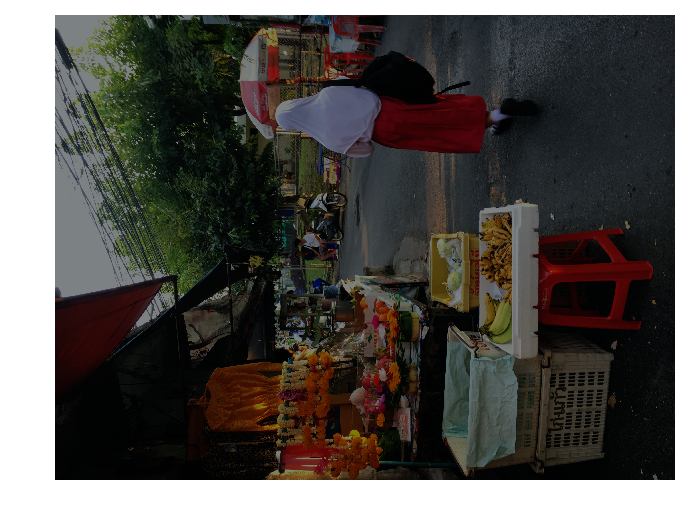

In [36]:
# JPEG撮影画像をフィルム（階調・色調）再現処理してみる
# （使用特性は Kodachrome 25）

img = np.array( Image.open( 'IMG_1706.JPG' ) ) 
img = ( img ).astype(np.float) / 255. # 8 bit =最大255で除して0-1にする
linImg = srgbImg2linImg( img ) # sRGB画像を光量線形画像に変換
filmImg = exposure2Density( linImg, 1, -1, [3.8, 3.6,3.5] ) # Kodachrome 25
sRGBFilmImage = linImg2srgbImg( filmImg )
plt.figure( figsize=(8, 8), dpi=100 ); plt.axis( "off" ); plt.imshow( sRGBFilmImage )

/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


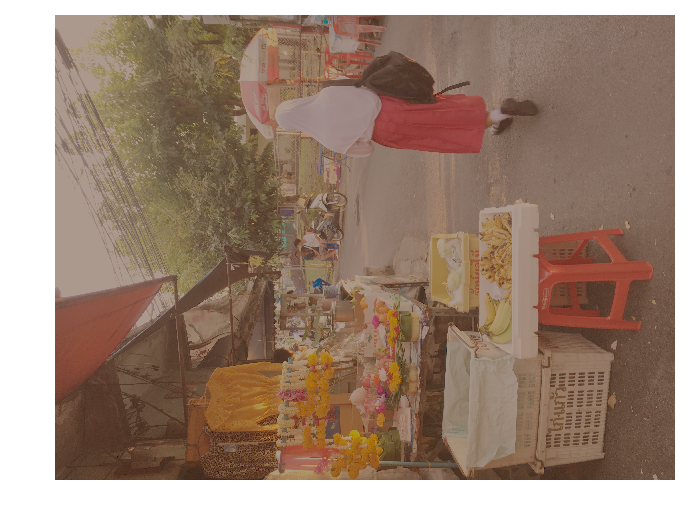

In [37]:
# JPEG撮影画像をフィルム（階調・色調）再現処理してみる
# （使用特性は old Fuji HG 1600）

img = np.array( Image.open( 'IMG_1706.JPG' ) ) 
img = ( img ).astype(np.float) / 255. # 8 bit =最大255で除して0-1にする
linImg = srgbImg2linImg( img ) # sRGB画像を光量線形画像に変換
filmImg = exposure2Density( linImg, 3, -1.5, [2.1, 2.7, 3.1] ) # old Fuji HG 1600
sRGBFilmImage = linImg2srgbImg( filmImg )
plt.figure( figsize=(8, 8), dpi=100 ); plt.axis( "off" ); plt.imshow( sRGBFilmImage )

/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


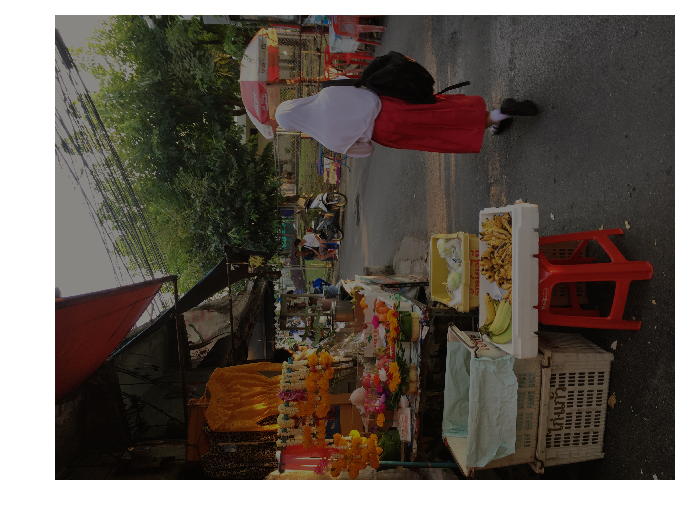

In [38]:
# JPEG撮影画像をフィルム（階調・色調）再現処理してみる
# （使用特性は old Fuji Astia 100）

img = np.array( Image.open( 'IMG_1706.JPG' ) ) 
img = ( img ).astype(np.float) / 255. # 8 bit =最大255で除して0-1にする
linImg = srgbImg2linImg( img ) # sRGB画像を光量線形画像に変換
filmImg = exposure2Density( linImg, 1.25, -1.25, [3.3, 3.4, 3.5] ) # old Fuji Astia 100
sRGBFilmImage = linImg2srgbImg( filmImg )
plt.figure( figsize=(8, 8), dpi=100 ); plt.axis( "off" ); plt.imshow( sRGBFilmImage )

/anaconda3/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


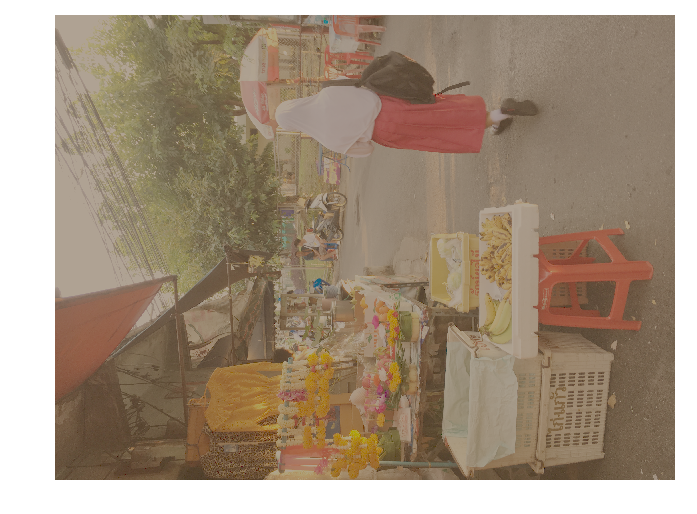

In [39]:
# JPEG撮影画像をフィルム（階調・色調）再現処理してみる
# （使用特性は Konica Cent_Super 200 ）

img = np.array( Image.open( 'IMG_1706.JPG' ) ) 
img = ( img ).astype(np.float) / 255. # 8 bit =最大255で除して0-1にする
linImg = srgbImg2linImg( img ) # sRGB画像を光量線形画像に変換
filmImg = exposure2Density( linImg, 3, -2, [2.0, 2.4, 2.9] ) # Konica Cent_Super 200 
sRGBFilmImage = linImg2srgbImg( filmImg )
plt.figure( figsize=(8, 8), dpi=100 ); plt.axis( "off" ); plt.imshow( sRGBFilmImage )